<h1 style="text-align:center; font-size:50px;">Laptop Price Prediction</h1>

virtual enviroment: laptop\Scripts\activate


1- Libraries

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import re
import mlflow
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

2 - Dataset Import and Feature Computation

In [7]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [8]:
# file path
file_path = r"C:\Users\manue\Desktop\DataScience\Datasets\laptop_data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df.head(5)

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [9]:
rows, columns = df.shape
print(f"The dataset has {columns} columns and {rows} rows.")

The dataset has 12 columns and 1303 rows.


In [10]:
column_names = df.columns.values
column_names

array(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype=object)

2 - Data Cleaning

In [11]:
# Null values in the dataset
null_values = df.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), 'null_values', 'Null values in the dataset')

# Percentage of missing values for each feature
missing_percentage = (df.isnull().sum() / len(df)) * 100
html_missing_percentage = create_scrollable_table(missing_percentage.to_frame(), 'missing_percentage', 'Percentage of missing values for each feature')

display(HTML(html_null_values + html_missing_percentage))

,0
Unnamed: 0,0
Company,0
TypeName,0
Inches,0
ScreenResolution,0
Cpu,0
Ram,0
Memory,0
Gpu,0
OpSys,0


In [12]:
# Check for duplicates

duplicates = df.duplicated().sum()
print(f"There are {duplicates} duplicated rows.")

There are 0 duplicated rows.


In [13]:
# Check value types

df.dtypes

Unnamed: 0            int64
Company              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object

In [14]:
# There are many columns that are objects, but to the analysis, would be better if they were numerical. 

In [15]:
# Working out the column ScreenResolution

unique_values_screen = df['ScreenResolution'].unique()
print(unique_values_screen)

['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / Touchscreen 1920x1080'
 'Full HD / Touchscreen 1920x1080' 'Touchscreen / Quad HD+ 3200x1800'
 'IPS Panel Touchscreen 1920x1200' 'Touchscreen 2256x1504'
 'Quad HD+ / Touchscreen 3200x1800' 'IPS Panel 1366x768'
 'IPS Panel 4K Ultra HD / Touchscreen 3840x2160'
 'IPS Panel Full HD 2160x1440' '4K Ultra HD / Touchscreen 3840x2160'
 'Touchscreen 2560x1440' '1600x900' 'IPS Panel 4K Ultra HD 3840x2160'
 '4K Ultra HD 3840x2160' 'Touchscreen 1366x768'
 'IPS Panel Full HD 1366x768' 'IPS Panel 2560x1440'
 'IPS Panel Full HD 2560x1440' 'IPS Panel Retina Display 2736x1824'
 'Touchscreen 2400x1600' '2560x1440' 'IPS Panel Quad HD+ 2560x1440'
 'IPS Panel Quad HD+ 3200x1800'
 'IPS Panel Quad HD+ / Touchscreen 3200x1800'
 'IPS Panel Touchscreen 1366x768' '1920x1080'
 'IPS Panel Full HD 1920x1200'
 'IP

In [16]:
# This variable can be broken down into three, Screentype which is going to be categorical, and ScreenHeight and ScreenWidth, both numerical.

In [17]:
# Function to extract ScreenWidth, ScreenHeight, and ScreenType
def extract_screen_info(resolution):
    if pd.isna(resolution):
        return None, None, None
    resolution = str(resolution)
    
    # Extracting the width and height
    resolution_parts = resolution.split(' ')
    for part in resolution_parts:
        if 'x' in part:
            screen_width, screen_height = part.split('x')
            screen_width = int(screen_width)
            screen_height = int(screen_height)
            break
    else:
        screen_width, screen_height = None, None  # Handle case if no resolution found
    
    # Extracting the screen type (everything before the first numeric part)
    screen_type = ' '.join([word for word in resolution_parts if not word.isdigit() and 'x' not in word])
    
    return screen_width, screen_height, screen_type.strip()

# Apply the function to extract the information
df[['ScreenWidth', 'ScreenHeight', 'ScreenType']] = df['ScreenResolution'].apply(lambda x: pd.Series(extract_screen_info(x)))

# Display the updated dataframe
df[['ScreenResolution', 'ScreenWidth', 'ScreenHeight', 'ScreenType']].head()

,ScreenResolution,ScreenWidth,ScreenHeight,ScreenType
0,IPS Panel Retina Display 2560x1600,2560,1600,IPS Panel Retina Display
1,1440x900,1440,900,
2,Full HD 1920x1080,1920,1080,Full HD
3,IPS Panel Retina Display 2880x1800,2880,1800,IPS Panel Retina Display
4,IPS Panel Retina Display 2560x1600,2560,1600,IPS Panel Retina Display


In [18]:
# The column Cpu can be broken down into cpu_Brand, cpu_Model and cpu_Clockspped to give more power to the analysis

unique_values_cpu = df['Cpu'].unique()
print(unique_values_cpu)

['Intel Core i5 2.3GHz' 'Intel Core i5 1.8GHz'
 'Intel Core i5 7200U 2.5GHz' 'Intel Core i7 2.7GHz'
 'Intel Core i5 3.1GHz' 'AMD A9-Series 9420 3GHz' 'Intel Core i7 2.2GHz'
 'Intel Core i7 8550U 1.8GHz' 'Intel Core i5 8250U 1.6GHz'
 'Intel Core i3 6006U 2GHz' 'Intel Core i7 2.8GHz'
 'Intel Core M m3 1.2GHz' 'Intel Core i7 7500U 2.7GHz'
 'Intel Core i7 2.9GHz' 'Intel Core i3 7100U 2.4GHz'
 'Intel Atom x5-Z8350 1.44GHz' 'Intel Core i5 7300HQ 2.5GHz'
 'AMD E-Series E2-9000e 1.5GHz' 'Intel Core i5 1.6GHz'
 'Intel Core i7 8650U 1.9GHz' 'Intel Atom x5-Z8300 1.44GHz'
 'AMD E-Series E2-6110 1.5GHz' 'AMD A6-Series 9220 2.5GHz'
 'Intel Celeron Dual Core N3350 1.1GHz' 'Intel Core i3 7130U 2.7GHz'
 'Intel Core i7 7700HQ 2.8GHz' 'Intel Core i5 2.0GHz'
 'AMD Ryzen 1700 3GHz' 'Intel Pentium Quad Core N4200 1.1GHz'
 'Intel Atom x5-Z8550 1.44GHz' 'Intel Celeron Dual Core N3060 1.6GHz'
 'Intel Core i5 1.3GHz' 'AMD FX 9830P 3GHz' 'Intel Core i7 7560U 2.4GHz'
 'AMD E-Series 6110 1.5GHz' 'Intel Core i5 620

In [19]:
# Function to extract CPU brand, model, and clock speed
def extract_cpu_info(cpu_str):
    if pd.isna(cpu_str):
        return None, None, None
    
    # regex to extract brand, model, and clock speed
    cpu_str = cpu_str.strip().lower()
    brand = None
    model = None
    speed = None
    
    if 'intel' in cpu_str:
        brand = 'Intel'
    elif 'amd' in cpu_str:
        brand = 'AMD'
    elif 'samsung' in cpu_str:
        brand = 'Samsung'
    
    # Extract the model, for example: 'Core i5', 'Ryzen'
    match = re.search(r'(intel|amd|samsung) (core [a-z0-9]+|ryzen|pentium|atom|xeon|cortex)', cpu_str)
    if match:
        model = match.group(0)
    
    # Extract clock speed (e.g., 2.3GHz)
    speed_match = re.search(r'(\d+(\.\d+)?)ghz', cpu_str)
    if speed_match:
        speed = float(speed_match.group(1))
    
    return brand, model, speed

# Apply the function to the Cpu column and create new columns for brand, model, and speed
df[['Cpu_Brand', 'Cpu_Model', 'Cpu_ClockSpeed']] = df['Cpu'].apply(lambda x: pd.Series(extract_cpu_info(x)))

# View unique values for the new columns
print(df['Cpu_Brand'].unique())
print(df['Cpu_Model'].unique())
print(df['Cpu_ClockSpeed'].unique())

['Intel' 'AMD' 'Samsung']
['intel core i5' 'intel core i7' None 'intel core i3' 'intel core m'
 'intel atom' 'amd ryzen' 'intel pentium' 'intel xeon' 'samsung cortex']
[2.3  1.8  2.5  2.7  3.1  3.   2.2  1.6  2.   2.8  1.2  2.9  2.4  1.44
 1.5  1.9  1.1  1.3  2.6  3.6  3.2  1.   2.1  0.9  1.92]


In [20]:
# The variables Ram and Weight make more sense to have it as numerical.

df['Ram'] = df['Ram'].str.replace('GB', '').astype(float)
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

In [21]:
# Get unique values from the 'Memory' column
unique_memory_values = df['Memory'].unique()
unique_memory_values

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [22]:
# The memory column should be transformed into a numerical format since memory size directly impacts price, and then for every storage type a binary column is created

In [23]:
import re

# Function to process the Memory column and extract the memory size
def process_memory(memory):
    # Convert TB to GB
    memory = memory.replace("TB", "000GB")  # 1TB = 1000GB
    memory_parts = memory.split("+")

    total_storage = 0

    # Extract the sizes from each part and sum them
    for part in memory_parts:
        part = part.strip()
        match = re.search(r"(\d+)(GB|TB)", part)
        if match:
            size = int(match.group(1))
            # Convert TB to GB (if applicable)
            if match.group(2) == "TB":
                size *= 1000
            total_storage += size
    
    return total_storage

# Apply function to df['Memory'] for the memory size
df['Memory_Size'] = df['Memory'].apply(process_memory)

# Function to process the Memory column and extract the storage type
def process_storage_type(memory):
    # Convert TB to GB
    memory = memory.replace("TB", "000GB")  # 1TB = 1000GB
    memory_parts = memory.split("+")

    # Check for storage types and return the appropriate type
    if "Hybrid" in memory:
        return "Hybrid"
    elif "SSD" in memory:
        return "SSD"
    elif "Flash" in memory:
        return "Flash"
    elif "HDD" in memory:
        return "HDD"
    else:
        return "Unknown"  # In case no recognized type is found

# Apply function to df['Memory'] for the storage type
df['Storage_Type'] = df['Memory'].apply(process_storage_type)

# Now drop the original Memory column and keep Total_Storage_GB (if you have it)
df.drop(columns=['Memory'], inplace=True)


In [24]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price,ScreenWidth,ScreenHeight,ScreenType,Cpu_Brand,Cpu_Model,Cpu_ClockSpeed,Memory_Size,Storage_Type
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,2560,1600,IPS Panel Retina Display,Intel,intel core i5,2.3,128,SSD
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,Intel HD Graphics 6000,macOS,1.34,47895.5232,1440,900,,Intel,intel core i5,1.8,128,Flash
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,Intel HD Graphics 620,No OS,1.86,30636.0000,1920,1080,Full HD,Intel,intel core i5,2.5,256,SSD
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,AMD Radeon Pro 455,macOS,1.83,135195.3360,2880,1800,IPS Panel Retina Display,Intel,intel core i7,2.7,512,SSD
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,2560,1600,IPS Panel Retina Display,Intel,intel core i5,3.1,256,SSD


In [25]:
# Drop unnecesary columns
df = df.drop(columns=['Unnamed: 0', 'ScreenResolution', 'Cpu','Gpu'])

In [26]:
# Check value types

df.dtypes

Company            object
TypeName           object
Inches            float64
Ram               float64
OpSys              object
Weight            float64
Price             float64
ScreenWidth         int64
ScreenHeight        int64
ScreenType         object
Cpu_Brand          object
Cpu_Model          object
Cpu_ClockSpeed    float64
Memory_Size         int64
Storage_Type       object
dtype: object

In [27]:
# Check for Outliers

In [28]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.describe()

,Inches,Ram,Weight,Price,ScreenWidth,ScreenHeight,Cpu_ClockSpeed,Memory_Size
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,8.382195,2.038734,59870.042910,1894.784344,1070.830391,2.298772,601.694551
std,1.426304,5.084665,0.665475,37243.201786,494.641028,284.519410,0.506340,468.342177
min,10.100000,2.000000,0.690000,9270.720000,1366.000000,768.000000,0.900000,0.000000
25%,14.000000,4.000000,1.500000,31914.720000,1600.000000,900.000000,2.000000,256.000000
50%,15.600000,8.000000,2.040000,52054.560000,1920.000000,1080.000000,2.500000,500.000000
75%,15.600000,8.000000,2.300000,79274.246400,1920.000000,1080.000000,2.700000,1000.000000
max,18.400000,64.000000,4.700000,324954.720000,3840.000000,2160.000000,3.600000,2512.000000


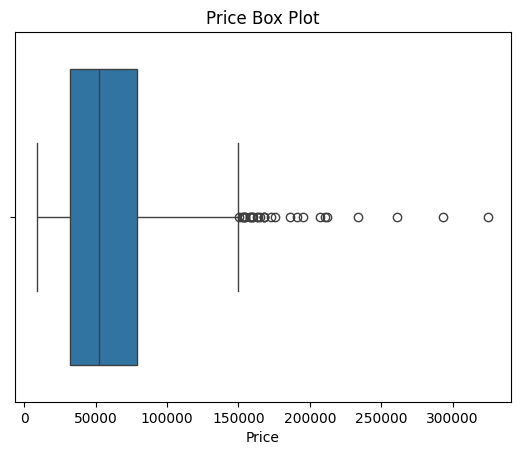

In [29]:
# Box plot for Price column
sns.boxplot(x=df['Price'])
plt.title('Price Box Plot')
plt.show()

In [30]:
#Elimination of Outliers

# Calculate the 1st and 99th percentiles for 'Price'
lower_percentile = df['Price'].quantile(0.01)
upper_percentile = df['Price'].quantile(0.99)

# Filter the DataFrame to exclude the top 1% most expensive and top 1% least expensive entries
df = df[(df['Price'] > lower_percentile) & (df['Price'] < upper_percentile)]

In [31]:
# Check for NaN values

df.replace('NaN', np.nan, inplace=True)
nan_counts = df.isnull().sum()
print(nan_counts)

Company             0
TypeName            0
Inches              0
Ram                 0
OpSys               0
Weight              0
Price               0
ScreenWidth         0
ScreenHeight        0
ScreenType          0
Cpu_Brand           0
Cpu_Model         133
Cpu_ClockSpeed      0
Memory_Size         0
Storage_Type        0
dtype: int64


In [32]:
df['Cpu_Model'] = df.groupby('Company')['Cpu_Model'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.ffill().bfill())
)


3 - EDA

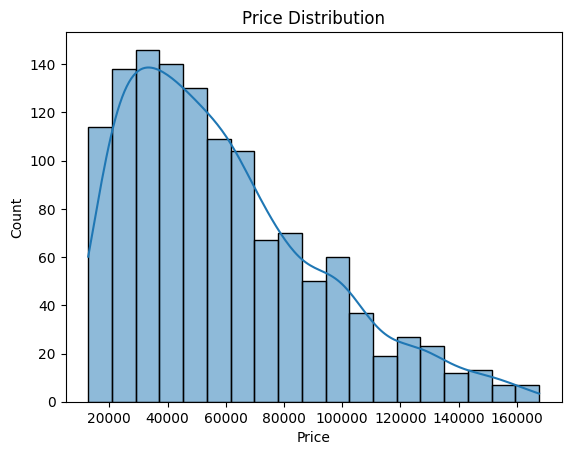

In [33]:
# Price Distribution

sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')
plt.show()

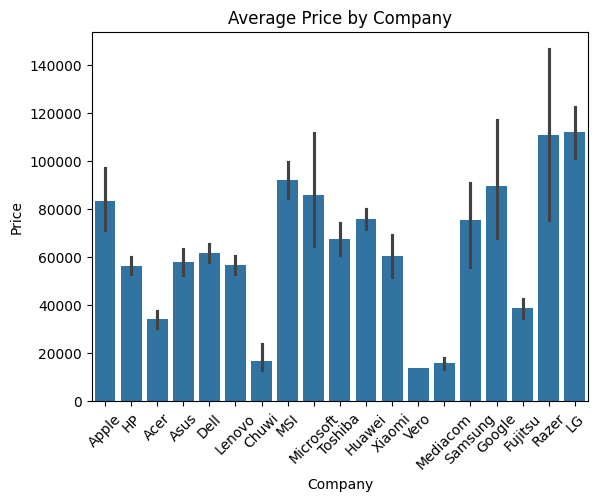

In [34]:
# Average Price by Company

sns.barplot(x='Company', y='Price', data=df)
plt.title('Average Price by Company')
plt.xticks(rotation=45)
plt.show()

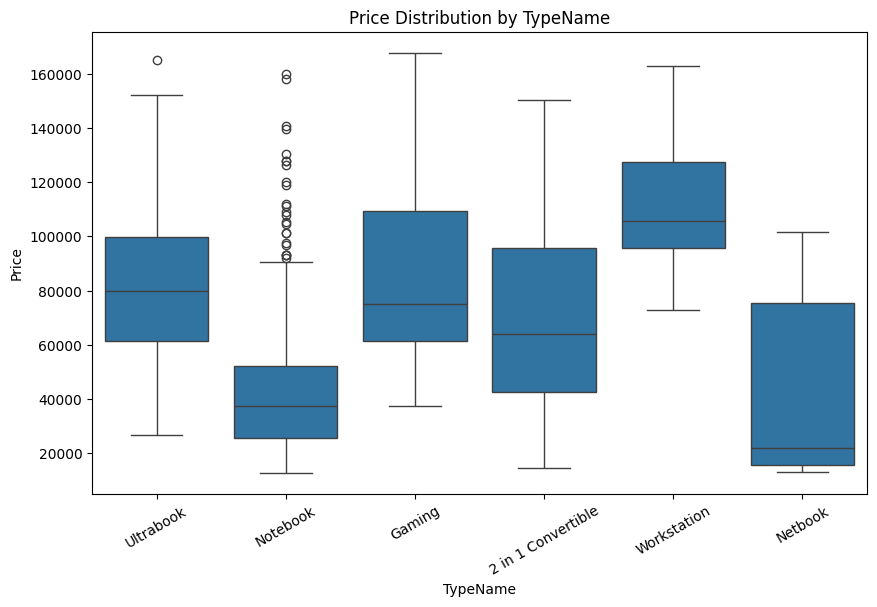

In [35]:
# Price Distribution by Typename

plt.figure(figsize=(10, 6)) 
sns.boxplot(x='TypeName', y='Price', data=df)
plt.title('Price Distribution by TypeName')
plt.xticks(rotation=30)  
plt.show()

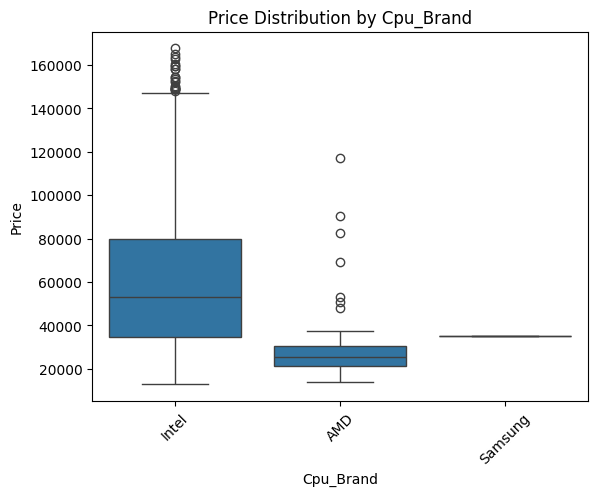

In [36]:
sns.boxplot(x='Cpu_Brand', y='Price', data=df)
plt.title('Price Distribution by Cpu_Brand')
plt.xticks(rotation=45)
plt.show()

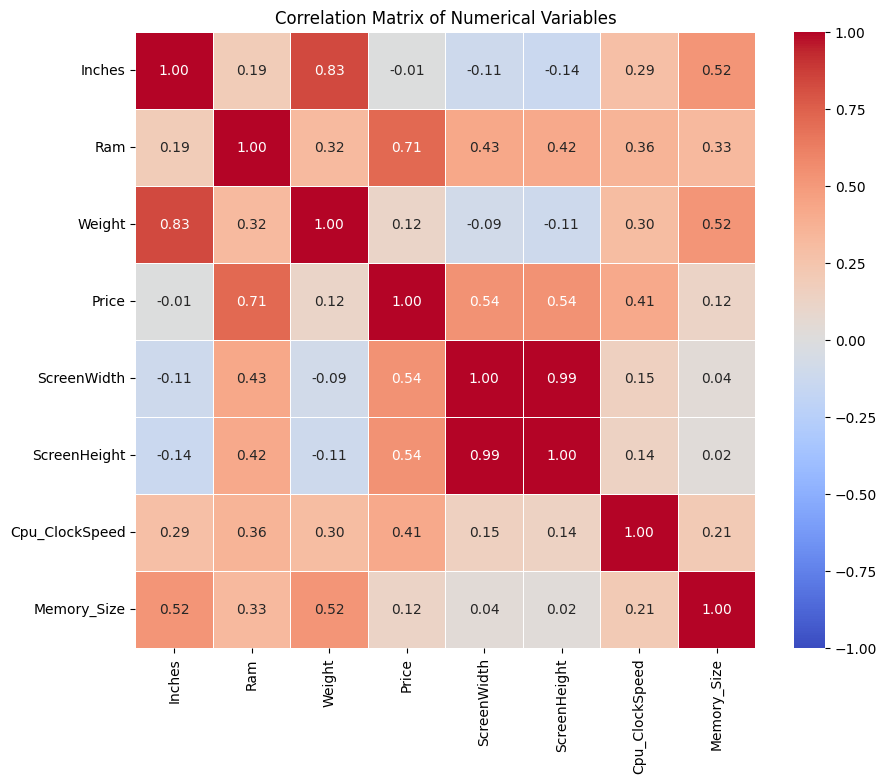

In [37]:
# Correlation Matrix

# numerical columns from the DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the numerical columns
correlation_matrix = numerical_columns.corr()


plt.figure(figsize=(10, 8))  # 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [38]:
# There is a notable positive correlation between the price and the memory ram, the size of the screen, the clock speed and the SSD.

In [39]:
# Get unique values from the 'Memory' column
unique_memory_values = df['Inches'].unique()
unique_memory_values

array([13.3, 15.6, 15.4, 14. , 12. , 17.3, 10.1, 13.5, 12.5, 13. , 18.4,
       13.9, 11.6, 12.3, 17. , 15. , 14.1, 11.3])

In [40]:
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price,ScreenWidth,ScreenHeight,ScreenType,Cpu_Brand,Cpu_Model,Cpu_ClockSpeed,Memory_Size,Storage_Type
0,Apple,Ultrabook,13.3,8.0,macOS,1.37,71378.6832,2560,1600,IPS Panel Retina Display,Intel,intel core i5,2.3,128,SSD
1,Apple,Ultrabook,13.3,8.0,macOS,1.34,47895.5232,1440,900,,Intel,intel core i5,1.8,128,Flash
2,HP,Notebook,15.6,8.0,No OS,1.86,30636.0000,1920,1080,Full HD,Intel,intel core i5,2.5,256,SSD
3,Apple,Ultrabook,15.4,16.0,macOS,1.83,135195.3360,2880,1800,IPS Panel Retina Display,Intel,intel core i7,2.7,512,SSD
4,Apple,Ultrabook,13.3,8.0,macOS,1.37,96095.8080,2560,1600,IPS Panel Retina Display,Intel,intel core i5,3.1,256,SSD


Data Processing

In [41]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

Categorical columns: ['Company', 'TypeName', 'OpSys', 'ScreenType', 'Cpu_Brand', 'Cpu_Model', 'Storage_Type']


In [42]:
numerical_cols = ['Inches', 'Ram', 'Weight', 'ScreenWidth', 'ScreenHeight', 'Memory_Size']
print(f"Numerical columns: {numerical_cols}")

Numerical columns: ['Inches', 'Ram', 'Weight', 'ScreenWidth', 'ScreenHeight', 'Memory_Size']


In [43]:
# preprocessor with one-hot encoding for categorical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),              # Scaling numerical features
        ('cat', OneHotEncoder(), categorical_cols)               # One-hot encoding categorical features
    ])

In [44]:
# Apply preprocessor and model in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [45]:
# Apply transformation
X = df.drop(columns='Price')  
y = df['Price']

In [46]:
X_transformed = pipeline.fit_transform(X)

In [47]:
# Convert sparse matrix to dense (array or DataFrame)
X_transformed_df = pd.DataFrame(X_transformed.toarray())  # Converts to dense DataFrame

In [48]:
# Get feature names from the preprocessor
num_features = numerical_cols  # Scaled numerical columns
cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)  # One-hot encoded features

# Combine numerical and categorical feature names
all_features = np.concatenate([num_features, cat_features])

# Update the column names of the transformed DataFrame
X_transformed_df.columns = all_features

# Concatenate X_transformed with y (target variable)
final_df = pd.concat([X_transformed_df, y], axis=1)

In [49]:

final_df.head()

,Inches,Ram,Weight,ScreenWidth,ScreenHeight,Memory_Size,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,...,Cpu_Model_intel core m,Cpu_Model_intel pentium,Cpu_Model_intel xeon,Cpu_Model_samsung cortex,Cpu_Model_None,Storage_Type_Flash,Storage_Type_HDD,Storage_Type_Hybrid,Storage_Type_SSD,Price
0,-1.219861,-0.053564,-1.025444,1.396552,1.923881,-1.025244,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71378.6832
1,-1.219861,-0.053564,-1.072160,-0.942288,-0.612095,-1.025244,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,47895.5232
2,0.414827,-0.053564,-0.262422,0.060072,0.040013,-0.749209,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30636.0000
3,0.272681,1.740818,-0.309138,2.064792,2.648445,-0.197140,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,135195.3360
4,-1.219861,-0.053564,-1.025444,1.396552,1.923881,-0.749209,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96095.8080


In [50]:
# Drop the specified columns from final_df
columns_to_drop = ['Company', 'TypeName', 'OpSys', 'ScreenType', 'Cpu_Brand', 'Cpu_Model', 'Storage_Type',
                   'Inches', 'Ram', 'Weight', 'ScreenWidth', 'ScreenHeight', 'Memory_Size']

# Filter columns that exist in the DataFrame
columns_to_drop_existing = [col for col in columns_to_drop if col in final_df.columns]

# Drop the existing columns
final_df = final_df.drop(columns=columns_to_drop_existing)

print(f"Dropped columns: {columns_to_drop_existing}")

Dropped columns: ['Inches', 'Ram', 'Weight', 'ScreenWidth', 'ScreenHeight', 'Memory_Size']


In [51]:
# Check if all columns in final_df are numerical
numerical_columns = final_df.select_dtypes(include=['number']).columns
all_numerical = len(numerical_columns) == len(final_df.columns)

print("All columns are numerical:", all_numerical)

All columns are numerical: True


In [52]:
# Check for NaN values in the entire DataFrame
print("Any NaN values in final_df?", final_df.isna().any().any())

# Count the number of NaN values in each column
print("Number of NaN values per column:")
print(final_df.isna().sum())

# Alternatively, you can get a more detailed view of rows with NaN values
print("Rows with NaN values:")
print(final_df[final_df.isna().any(axis=1)])


Any NaN values in final_df? True
Number of NaN values per column:
Company_Acer           26
Company_Apple          26
Company_Asus           26
Company_Chuwi          26
Company_Dell           26
                       ..
Storage_Type_Flash     26
Storage_Type_HDD       26
Storage_Type_Hybrid    26
Storage_Type_SSD       26
Price                  26
Length: 73, dtype: int64
Rows with NaN values:


      Company_Acer  Company_Apple  Company_Asus  Company_Chuwi  Company_Dell  \
20             0.0            0.0           0.0            0.0           0.0   
31             0.0            0.0           0.0            0.0           1.0   
67             0.0            0.0           0.0            0.0           0.0   
196            0.0            0.0           0.0            0.0           1.0   
238            0.0            0.0           0.0            0.0           1.0   
290            1.0            0.0           0.0            0.0           0.0   
555            0.0            0.0           0.0            0.0           0.0   
610            0.0            0.0           0.0            0.0           0.0   
723            0.0            0.0           0.0            0.0           0.0   
744            0.0            0.0           0.0            0.0           0.0   
749            0.0            0.0           0.0            0.0           0.0   
780            0.0            0.0       

In [53]:
# Drop rows with NaN values in place
final_df.dropna(inplace=True)

# Verify if any NaN values remain
print("Any NaN values in final_df?", final_df.isna().any().any())

Any NaN values in final_df? False


In [54]:
output_path = r"C:\Users\manue\Desktop\DataScience\Datasets\clean_laptop_data.csv"

# Export the DataFrame to CSV
final_df.to_csv(output_path, index=False, encoding='utf-8')

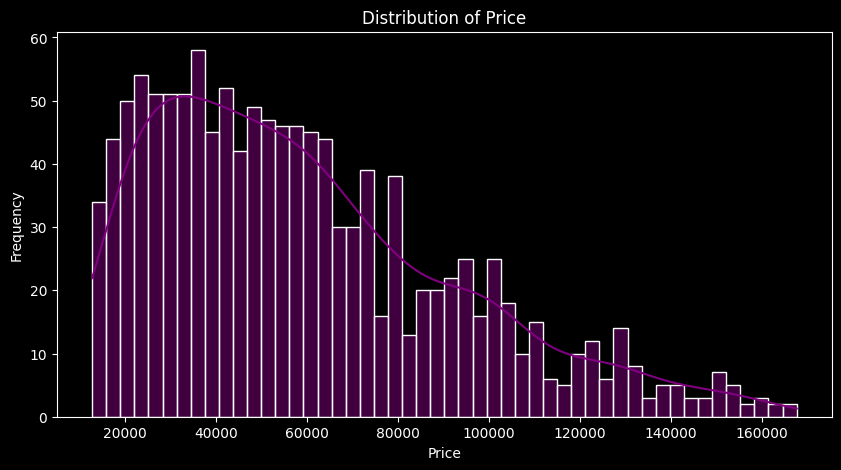

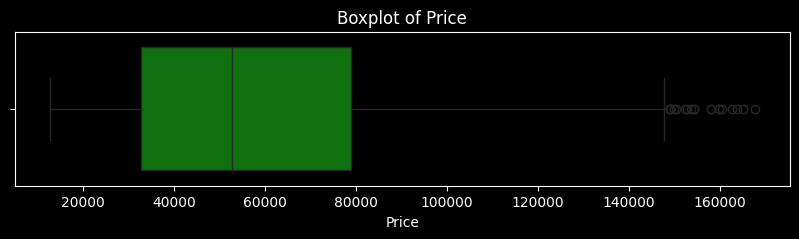

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set dark theme
plt.style.use("dark_background")

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(final_df['Price'], bins=50, kde=True, color="purple")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price")
plt.show()

# Box plot
plt.figure(figsize=(10, 2))
sns.boxplot(x=final_df['Price'], color="green")
plt.xlabel("Price")
plt.title("Boxplot of Price")
plt.show()


Tracking

In [56]:
# MLflow Tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("XGBoost_Regressor")

# Define the different sets of parameters for 5 runs
param_sets = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8},
    {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0},
    {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.2, 'subsample': 0.7},
    {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.85},
]

# Iterate over the parameter sets and run experiments
for i, params in enumerate(param_sets):
    with mlflow.start_run(run_name=f"Run_{i+1}"):
        # Log tags
        mlflow.set_tag("author", "Manuel Contreras")
        mlflow.set_tag("dataset", "Clean_Laptop_Prices")

        # Log the parameters for this run
        mlflow.log_params(params)

        # Create and fit the XGBoost model
        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **params)
        xg_reg.fit(xtrain_pca, y_train)  # No scaling on target

        # Predictions and evaluation
        xg_pred = xg_reg.predict(xtest_pca)

        # Compute MSE on the original scale
        xg_mse = mean_squared_error(y_test, xg_pred)
        
        # Compute R² Score
        xg_r2 = r2_score(y_test, xg_pred)

        # Log the metrics
        mlflow.log_metric("Mean Squared Error", xg_mse)
        mlflow.log_metric("R2 Score", xg_r2)

        print(f"Run {i+1} MSE on original scale: {xg_mse}")
        print(f"Run {i+1} R² Score: {xg_r2}")

print("All runs completed and logged in MLflow.")



# MLflow Tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Random_Forest_Regressor")

# Define the different sets of parameters for 5 runs (Random Forest hyperparameters)
param_sets = [
    {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2},
    {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3},
    {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4},
    {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2},
]

# Iterate over the parameter sets and run experiments
for i, params in enumerate(param_sets):
    with mlflow.start_run(run_name=f"Run_{i+1}"):
        # Log tags
        mlflow.set_tag("author", "Manuel Contreras")
        mlflow.set_tag("dataset", "Clean_Laptop_Prices")

        # Log the parameters for this run
        mlflow.log_params(params)

        # Create and fit the Random Forest model
        rf_reg = RandomForestRegressor(**params)
        rf_reg.fit(xtrain_pca, y_train)  # No scaling on target

        # Predictions and evaluation
        rf_pred = rf_reg.predict(xtest_pca)

        # Compute MSE on the original scale
        rf_mse = mean_squared_error(y_test, rf_pred)
        
        # Compute R² Score
        rf_r2 = r2_score(y_test, rf_pred)

        # Log the metrics
        mlflow.log_metric("Mean Squared Error", rf_mse)
        mlflow.log_metric("R2 Score", rf_r2)

        print(f"Run {i+1} MSE on original scale: {rf_mse}")
        print(f"Run {i+1} R² Score: {rf_r2}")

print("All runs completed and logged in MLflow.")


NameError: name 'xgb' is not defined

   Company_Acer  Company_Apple  Company_Asus  Company_Chuwi  Company_Dell  \
0           0.0            1.0           0.0            0.0           0.0   
1           0.0            1.0           0.0            0.0           0.0   
2           0.0            0.0           0.0            0.0           0.0   
3           0.0            1.0           0.0            0.0           0.0   
4           0.0            1.0           0.0            0.0           0.0   

   Company_Fujitsu  Company_Google  Company_HP  Company_Huawei  Company_LG  \
0              0.0             0.0         0.0             0.0         0.0   
1              0.0             0.0         0.0             0.0         0.0   
2              0.0             0.0         1.0             0.0         0.0   
3              0.0             0.0         0.0             0.0         0.0   
4              0.0             0.0         0.0             0.0         0.0   

   ...  Cpu_Model_intel core m  Cpu_Model_intel pentium  Cpu_Model_i

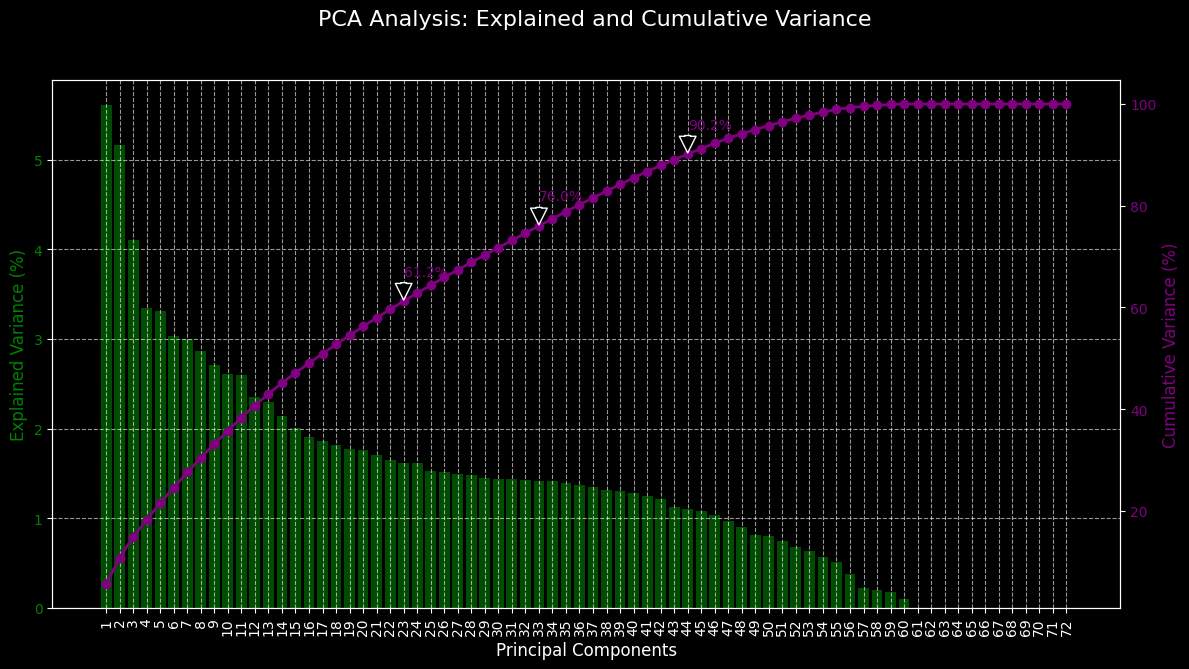

Run 1 MSE on original scale: 1211152630.7019455
Run 1 R² Score: -0.12737540049688256
Run 2 MSE on original scale: 1220807651.1381238
Run 2 R² Score: -0.13636256879848085
Run 3 MSE on original scale: 1327035508.1524084
Run 3 R² Score: -0.23524248682829718
Run 4 MSE on original scale: 1195313045.51561
Run 4 R² Score: -0.1126314629943066
Run 5 MSE on original scale: 1234735038.972529
Run 5 R² Score: -0.14932657848616815
All runs completed and logged in MLflow.
Run 1 MSE on original scale: 1087851330.5661201
Run 1 R² Score: -0.012603034819198555
Run 2 MSE on original scale: 1093505289.9437585
Run 2 R² Score: -0.017865901411053375
Run 3 MSE on original scale: 1117229540.807502
Run 3 R² Score: -0.03994911053020456
Run 4 MSE on original scale: 1090977979.4045994
Run 4 R² Score: -0.01551340870366169
Run 5 MSE on original scale: 1123632944.2984931
Run 5 R² Score: -0.04590958107058185
All runs completed and logged in MLflow.


In [57]:
# Data Handling
import numpy as np
import pandas as pd

# Machine Learning Models
from sklearn.svm import SVR               # Support Vector Machine Regressor
from xgboost import XGBRegressor          # XGBoost Regressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Data Preprocessing
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.preprocessing import StandardScaler      # Feature Scaling

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics

# MLflow
import mlflow

# File path
file_path = r"C:\Users\manue\Desktop\DataScience\Datasets\clean_laptop_data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
print(df.head(5))

df.shape

# Assuming 'df' is your dataframe and 'Price' is the target variable
X = df.drop('Price', axis=1)  # Features
y = df['Price']  # Target

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and apply StandardScaler to features (X), not the target (y)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the number of components
n_comps = 72
components = range(1, n_comps + 1)

# Create PCA instance
pca = PCA(n_components=n_comps)

# Fit the PCA model with X_train_scaled
pca.fit(X_train_scaled)

# Transform the data
xpca = pca.transform(X_train_scaled)

# Percentage of variance explained by each principal component
eigenvalues = pca.explained_variance_ratio_

# Cumulative sum of explained variance
eigenvalues_acum = eigenvalues.cumsum()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Title
fig.suptitle('PCA Analysis: Explained and Cumulative Variance', fontsize=16)

# Left axis
ax1.set_xlabel('Principal Components', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', color='green', fontsize=12)
ax1.bar(components, eigenvalues * 100, color='green', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(range(1, n_comps + 1))
ax1.set_xticklabels(range(1, n_comps + 1), rotation=90)  # Rotate x-axis labels
ax1.grid(True, linestyle='--', alpha=0.6)

# Right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Variance (%)', color='purple', fontsize=12)
ax2.plot(components, eigenvalues_acum * 100, color='purple', marker='o', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor='purple')

# Annotate cumulative variance at key points (e.g., 60%, 75%, 90%)
for i, value in enumerate(eigenvalues_acum * 100):
    if value >= 60 and (i == 0 or eigenvalues_acum[i-1] * 100 < 60):
        ax2.annotate(f'{value:.1f}%', 
                     xy=(components[i], value), 
                     xytext=(components[i], value + 5),
                     textcoords='data',
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, color='purple')
    if value >= 75 and (i == 0 or eigenvalues_acum[i-1] * 100 < 75):
        ax2.annotate(f'{value:.1f}%', 
                     xy=(components[i], value), 
                     xytext=(components[i], value + 5),
                     textcoords='data',
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, color='purple')
    if value >= 90 and (i == 0 or eigenvalues_acum[i-1] * 100 < 90):
        ax2.annotate(f'{value:.1f}%', 
                     xy=(components[i], value), 
                     xytext=(components[i], value + 5),
                     textcoords='data',
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, color='purple')

# Improve layout and show plot
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
plt.show()


# with 49 PCA we get to explain almost all the variance
n_comps = 44

from sklearn.decomposition import PCA
pca = PCA(n_components=n_comps)
pca.fit(X_train_scaled)

# Transform the data into the top 5 PCs
xtrain_pca = pca.transform(X_train_scaled)
xtest_pca = pca.transform(X_test_scaled)




# MLflow Tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("XGBoost_Regressor")

# Define the different sets of parameters for 5 runs
param_sets = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8},
    {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0},
    {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.2, 'subsample': 0.7},
    {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.85},
]

# Iterate over the parameter sets and run experiments
for i, params in enumerate(param_sets):
    with mlflow.start_run(run_name=f"Run_{i+1}"):
        # Log tags
        mlflow.set_tag("author", "Manuel Contreras")
        mlflow.set_tag("dataset", "Clean_Laptop_Prices")

        # Log the parameters for this run
        mlflow.log_params(params)

        # Create and fit the XGBoost model
        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **params)
        xg_reg.fit(xtrain_pca, y_train)  # No scaling on target

        # Predictions and evaluation
        xg_pred = xg_reg.predict(xtest_pca)

        # Compute MSE on the original scale
        xg_mse = mean_squared_error(y_test, xg_pred)
        
        # Compute R² Score
        xg_r2 = r2_score(y_test, xg_pred)

        # Log the metrics
        mlflow.log_metric("Mean Squared Error", xg_mse)
        mlflow.log_metric("R2 Score", xg_r2)

        print(f"Run {i+1} MSE on original scale: {xg_mse}")
        print(f"Run {i+1} R² Score: {xg_r2}")

print("All runs completed and logged in MLflow.")



# MLflow Tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Random_Forest_Regressor")

# Define the different sets of parameters for 5 runs (Random Forest hyperparameters)
param_sets = [
    {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2},
    {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3},
    {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4},
    {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2},
]

# Iterate over the parameter sets and run experiments
for i, params in enumerate(param_sets):
    with mlflow.start_run(run_name=f"Run_{i+1}"):
        # Log tags
        mlflow.set_tag("author", "Manuel Contreras")
        mlflow.set_tag("dataset", "Clean_Laptop_Prices")

        # Log the parameters for this run
        mlflow.log_params(params)

        # Create and fit the Random Forest model
        rf_reg = RandomForestRegressor(**params)
        rf_reg.fit(xtrain_pca, y_train)  # No scaling on target

        # Predictions and evaluation
        rf_pred = rf_reg.predict(xtest_pca)

        # Compute MSE on the original scale
        rf_mse = mean_squared_error(y_test, rf_pred)
        
        # Compute R² Score
        rf_r2 = r2_score(y_test, rf_pred)

        # Log the metrics
        mlflow.log_metric("Mean Squared Error", rf_mse)
        mlflow.log_metric("R2 Score", rf_r2)

        print(f"Run {i+1} MSE on original scale: {rf_mse}")
        print(f"Run {i+1} R² Score: {rf_r2}")

print("All runs completed and logged in MLflow.")